<a href="https://colab.research.google.com/github/pgada99/Machine-Learning-Algorithms-for-Predicting-Human-Fall/blob/main/deep_hedging.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

In [121]:
# data

S0    = 1    # initial stock price
K     = 1    # strike price
sigma = .20  # volatility
r     = 0    # risk-free rate
T     = 1    # maturity

m     = 365   # number of training samples
n     = 10**4 # number of trajectories of underlying

In [122]:
# model discretized black scholes hedge with neural networks

def generate_gbm(S0,sigma,r,T,m,n,random_seed = 42):
  ''' Generate stock price dinamics.
  Parameters
  -----------
  S0 : float
    initial stock price
  K : float
    strike price
  sigma : float
    volatility
  r : float
    risk-free rate
  T : float
    time to maturity
  n : int
    number of simulations
  '''
  np.random.seed(random_seed)
  bm = np.random.normal(0,1,(n,m))*np.sqrt(T/m)
  bm[:,0] = np.zeros(shape=(n))
  bm = np.cumsum(bm, axis = 1)
  t = np.tile(np.linspace(0,1,m),(n,1))
  S = S0*np.exp((r-sigma**2/2)*t + sigma*bm)

  return S

In [13]:
def bs_call_price(S,K,r,sigma,T,d=0):
	'''Computes Black-Scholes price of a Call Option.
	Parameters:
	------------------------------------
		S = stock prices (shape = (n,m))
			n = number of simulations
			m = number of time steps
		K = exercise price
		r = risk-free rate
		sigma = volatility
		T = time to maturity
		d = dividend-rate (optional)
	Returns:
	-----------------------------------
		price of the option
	'''
			# Ignore division by 0 warning (expected behaviors as the limits of CDF is defined).
			with np.errstate(divide='ignore'):
				d1 = np.divide(np.log(S / K) + (r - d + 0.5 * sigma ** 2) * T, sigma * np.sqrt(T))
				d2 = np.divide(np.log(S / K) + (r - d - 0.5 * sigma ** 2) * T, sigma * np.sqrt(T))
			
			return (S * norm.cdf(d1, 0.0, 1.0) - K * np.exp(-r * T) * norm.cdf(d2, 0.0, 1.0))

In [14]:
# black-scholes delta
def bs_call_delta(S,K,r,sigma,T,d=0):
  '''Computes Black-Scholes Delta of a Call Option.
	Parameters:
	------------------------------------
		S = stock prices (shape = (n,m))
			n = number of simulations
			m = number of time steps
		K = exercise price
		r = risk-free rate
		sigma = volatility
		T = time to maturity
		d = dividend-rate (optional)
	Returns:
	-----------------------------------
		delta of the option - N[d1]
  '''
  d1 = np.divide(np.log(S / K) + (r - d + 0.5 * sigma ** 2) * T, sigma * np.sqrt(T))
  return norm.cdf(d1,0,1)

Simulating 20 stock price movements.

In [123]:
stocks = generate_gbm(S0,sigma,r,T,m,n);

**Black-Scholes Hedge** | For a process $S_t$ the PnL will be the following: 

$$ \text{PnL} = \underbrace{C_{\text{BS}}-(S_T-K)^+}_{\text{Short-Call Position}} + \underbrace{\sum_{i=1}^m (S_{t_i}-S_{t_{i-1}})\cdot{\Delta_{\text{BS}}}({t_i})}_{\text{Underlying Price}}$$

where $\Delta_{t_i} = N[d_1]$.

In [117]:
# black scholes hedge
pnl = bs_call_price(stocks[:,0],K,r,sigma,T) - np.maximum(stocks[:,-1]-K, 0) + np.sum((stocks[:,1:]-stocks[:,0:-1])*(bs_call_delta(stocks[:,0:-1],K,r,sigma,np.vstack([T-np.linspace(0,T,m)[0:-1]]*n),d=0)),axis=1)

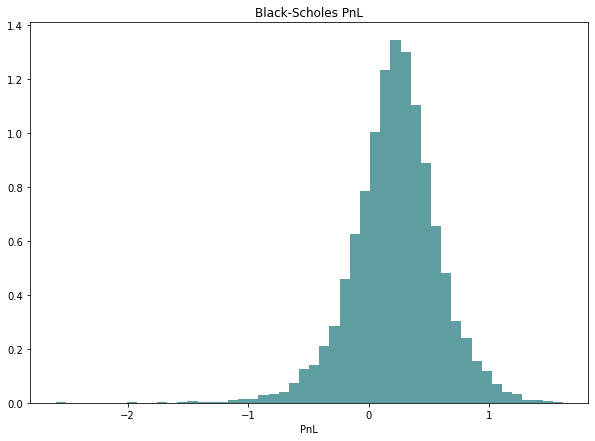

In [130]:
#pnl = bs_call_pnl(stocks, np.maximum(stocks[:,-1]-K,0), bs_call_delta(stocks[:,0:-1],K,r,sigma,np.vstack([T-np.linspace(0,T,m)[0:-1]]*n),d=0), )
plt.figure(figsize = (10,7))
plt.hist(pnl, bins = 50, color = 'cadetblue', density = True, label = 'Black-Scholes Hedge');
plt.title('Black-Scholes PnL');
plt.xlabel('PnL');

Text(0.5, 1.0, 'Delta')

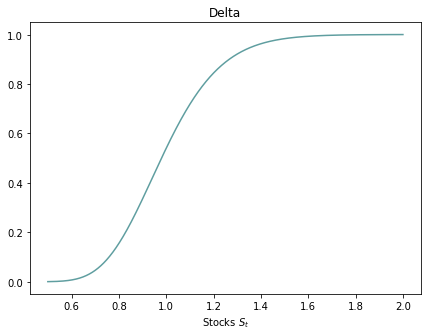

In [132]:
x = np.linspace(0.5,2,1000)
plt.figure(figsize = (7,5))
plt.plot(x, bs_call_delta(x,K,r,sigma,T), color = 'cadetblue');
plt.xlabel('Stocks $S_t$');
plt.title('Delta')

For practical purposes it not feasible to allow the policy to depend on the entire state space $S_t$. It is reasonable to assume that the hedging decision at some $t$ mainly depends on the prices of the hedging instruments and the current position in them. We may choose to work with transformed versions of the raw prices: for example, option prices are typically converted to “implied volatilities”, and equity prices are represented in terms of their logarithms. Our basic feature vector is therefore of the form $f = f (H)$.

In [79]:
def bs_call_pnl(S = None, payoff = None, delta = None, dt = None, risk_free = None, \
									final_period_cost = None, epsilon = None, cost_structure="proportional"):
		# Compute Black-Scholes PnL (for a short position, i.e. the Bank sells
		# a call option. The model delta from Quantlib is a long delta.
		N = S.shape[1]-1
		
		PnL_BS = np.multiply(S[:,0], -delta[:,0]) \
		
		if cost_structure == "proportional":
			PnL_BS -= np.abs(delta[:,0])*S[:,0]*epsilon
		elif cost_structure == "constant":
			PnL_BS -= epsilon
				
		PnL_BS = PnL_BS*np.exp(risk_free*dt)
		
		for t in range(1, N):
			PnL_BS += np.multiply(S[:,t], -delta[:,t] + delta[:,t-1])
			
			if cost_structure == "proportional":
				PnL_BS -= np.abs(delta[:,t] -delta[:,t-1])*S[:,t]*epsilon
			elif cost_structure == "constant":
				PnL_BS -= epsilon
				
			PnL_BS = PnL_BS*np.exp(risk_free*dt)

		PnL_BS += np.multiply(S[:,N],delta[:,N-1]) + payoff 
		
		if final_period_cost:
			if cost_structure == "proportional":
				PnL_BS -= np.abs(delta[:,N-1])*S[:,N]*epsilon
			elif cost_structure == "constant":
				PnL_BS -= epsilon
				
		return PnL_BS

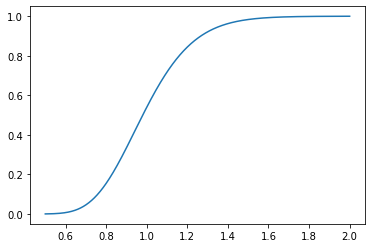

In [ ]:
x = np.linspace(0.5,2,1000)
plt.plot(x, bs_call_delta(x,K,r,sigma,T))

In [ ]:
def bs_call_pricing(S,T,r,K,sigma):
  (n,m) = np.shape(S)
  call = np.zeros(shape=(n,m))
  ttm = T-np.tile(np.linspace(0,T,m),(n,1))
  d1 = (np.log(S[:,0:-1]/K)+(r+sigma**2/2)*ttm[:,0:-1])/(sigma*np.sqrt(ttm[:,0:-1]));
  d2 = d1-sigma*np.sqrt(ttm[:,0:-1]);
  call[:,0:-1] = S[:,0:-1]*norm.pdf(d1)-K*np.exp(-r*ttm[:,0:-1])*norm.pdf(d2);
  call[:,-1] = np.max(S[:,-1]-K,0)
  return d1,d2,call

In [ ]:
d11,d22,calls = bs_call_pricing(stocks,T,r,K,sigma);

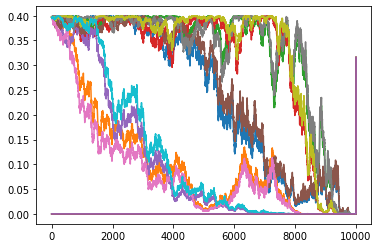

In [ ]:
plt.plot(norm.pdf(d22.T));
plt.plot(norm.pdf(d11.T));
plt.plot(calls.T)

In [ ]:
a = np.array([[1,2,3,4,5,6,7,8,9],[1,2,3,4,5,6,7,8,9]])
a[:,0:-1]=0
a[:,-1]=1
a

array([[0, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 1]])

In [ ]:
nn

5

In [ ]:
np.shape(stocks)

(10000, 5)

In [ ]:
stocks

array([[1.00058479, 1.00298474, 0.99763537, 0.99995133, 0.99978762],
       [0.99665727, 1.00092796, 1.00017669, 1.0006686 , 1.00143816],
       [0.99177022, 0.99958842, 1.00026064, 1.00154032, 1.00370176],
       ...,
       [0.73571344, 0.75279955, 0.96056176, 1.11104883, 0.96116492],
       [0.73402127, 0.75377108, 0.96153861, 1.11361372, 0.96237213],
       [0.73249986, 0.75128846, 0.96172866, 1.11258491, 0.96570923]])